# 전략

- Outlier 제거
- Feature Engineering
    - str to categorical int
- Feature Selection
- Oversampling by ADASYN
- tuned hyperparameter

# 라이브러리 임포트

In [220]:
! pip install -U pandas-profiling optuna

In [221]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_profiling
from xgboost import XGBClassifier
import xgboost
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import ADASYN
%matplotlib inline

# 데이터 불러오기

In [222]:
train = pd.read_csv('./dataset/train.csv')
test = pd.read_csv('./dataset/test.csv')
target = train['quality']

## id 칼럼 제거

In [223]:
train = train.drop('id', axis = 1)
test = test.drop('id', axis = 1)

In [224]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3231 entries, 0 to 3230
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         3231 non-null   float64
 1   volatile acidity      3231 non-null   float64
 2   citric acid           3231 non-null   float64
 3   residual sugar        3231 non-null   float64
 4   chlorides             3231 non-null   float64
 5   free sulfur dioxide   3231 non-null   float64
 6   total sulfur dioxide  3231 non-null   float64
 7   density               3231 non-null   float64
 8   pH                    3231 non-null   float64
 9   sulphates             3231 non-null   float64
 10  alcohol               3231 non-null   float64
 11  type                  3231 non-null   object 
 12  quality               3231 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 328.3+ KB


In [225]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3231 entries, 0 to 3230
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         3231 non-null   float64
 1   volatile acidity      3231 non-null   float64
 2   citric acid           3231 non-null   float64
 3   residual sugar        3231 non-null   float64
 4   chlorides             3231 non-null   float64
 5   free sulfur dioxide   3231 non-null   float64
 6   total sulfur dioxide  3231 non-null   float64
 7   density               3231 non-null   float64
 8   pH                    3231 non-null   float64
 9   sulphates             3231 non-null   float64
 10  alcohol               3231 non-null   float64
 11  type                  3231 non-null   object 
dtypes: float64(11), object(1)
memory usage: 303.0+ KB


## Outlier 제거

In [226]:
train = train[train.density < 1.03]
train.reset_index(drop=True, inplace=True)

In [227]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3230 entries, 0 to 3229
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         3230 non-null   float64
 1   volatile acidity      3230 non-null   float64
 2   citric acid           3230 non-null   float64
 3   residual sugar        3230 non-null   float64
 4   chlorides             3230 non-null   float64
 5   free sulfur dioxide   3230 non-null   float64
 6   total sulfur dioxide  3230 non-null   float64
 7   density               3230 non-null   float64
 8   pH                    3230 non-null   float64
 9   sulphates             3230 non-null   float64
 10  alcohol               3230 non-null   float64
 11  type                  3230 non-null   object 
 12  quality               3230 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 328.2+ KB


In [228]:
train

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type,quality
0,8.0,0.18,0.37,1.30,0.040,15.0,96.0,0.99120,3.06,0.61,12.1,white,6
1,7.5,0.38,0.29,4.90,0.021,38.0,113.0,0.99026,3.08,0.48,13.0,white,7
2,6.1,0.27,0.33,2.20,0.021,26.0,117.0,0.98860,3.12,0.30,12.5,white,6
3,6.4,0.32,0.50,10.70,0.047,57.0,206.0,0.99680,3.08,0.60,9.4,white,5
4,8.4,0.37,0.43,2.30,0.063,12.0,19.0,0.99550,3.17,0.81,11.2,red,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3225,6.4,0.16,0.31,5.30,0.043,42.0,157.0,0.99455,3.35,0.47,10.5,white,5
3226,6.4,0.18,0.28,17.05,0.047,53.0,139.0,0.99724,3.25,0.35,10.5,white,6
3227,6.0,0.28,0.25,1.80,0.042,8.0,108.0,0.99290,3.08,0.55,9.0,white,5
3228,7.7,0.28,0.29,6.90,0.041,29.0,163.0,0.99520,3.44,0.60,10.5,white,6


## type column 전처리
- str to categorical int

In [229]:
train.loc[train['type'] == 'white', 'type'] = 0
train.loc[train['type'] == 'red', 'type'] = 1
train['type'] = train['type'].astype('int')

test.loc[test['type'] == 'white', 'type'] = 0
test.loc[test['type'] == 'red', 'type'] = 1
test['type'] = test['type'].astype('int')

## PCA 차원 축소를 이용한 Feature 추가

In [230]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
train_pca = pca.fit_transform(train.drop('quality',axis=1))
test_pca = pca.transform(test)

In [231]:
train_pca = pd.DataFrame(train_pca, columns=['pca_1','pca_2'])
test_pca = pd.DataFrame(test_pca, columns=['pca_1', 'pca_2'])

In [232]:
train = pd.concat([train, train_pca], axis = 1)
test = pd.concat([test, test_pca], axis = 1)

## Feature Selection

In [233]:
train = train[[
    # 'id',
    'fixed acidity',
    'volatile acidity',
    'citric acid',
    'residual sugar',
    'chlorides',
    'free sulfur dioxide',
    'total sulfur dioxide',
    'density',
    'pH',
    'sulphates',
    'alcohol',
    # 'type',
    'quality',
    'pca_1',
    'pca_2'
]]

test = test[[
    'fixed acidity',
    'volatile acidity',
    'citric acid',
    'residual sugar',
    'chlorides',
    'free sulfur dioxide',
    'total sulfur dioxide',
    'density',
    'pH',
    'sulphates',
    'alcohol',
    # 'type',
    'pca_1',
    'pca_2',
]]


## Train Test Split

test set과 validation set으로 분리한다

In [234]:
from sklearn.model_selection import train_test_split
X_train_ = train.drop('quality', axis=1)
y_train_ = train['quality']
X_train, X_val, y_train, y_val = train_test_split(X_train_, y_train_, train_size = 0.7, shuffle=True, stratify=y_train_, random_state=42, )
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, shuffle=False, )

6    992
5    748
7    377
4     76
8     68
Name: quality, dtype: int64


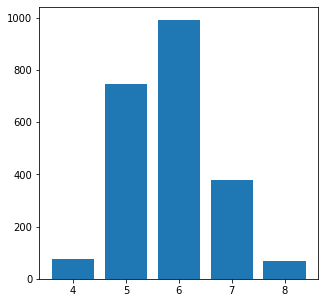

In [235]:
print(y_train.value_counts())

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
var = y_train.value_counts()
plt.bar(var.index, var)
plt.show()

6    425
5    321
7    162
4     32
8     29
Name: quality, dtype: int64


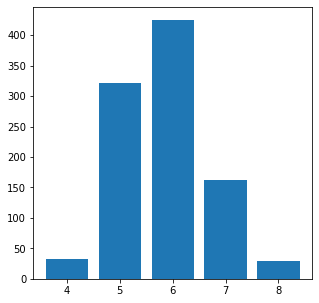

In [236]:
print(y_val.value_counts())

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
var = y_val.value_counts()
plt.bar(var.index, var)
plt.show()

## Over Sampling with ADASYN

Original Datset을 기준으로 Sampling

6    1417
5    1069
7     539
4     108
8      97
Name: quality, dtype: int64


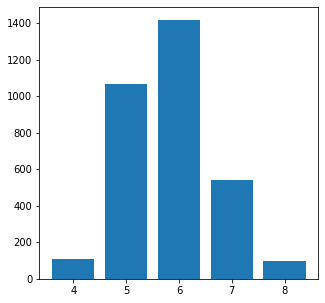

In [237]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
var = y_train_.value_counts()
print(var)
plt.bar(var.index, var)
plt.show()

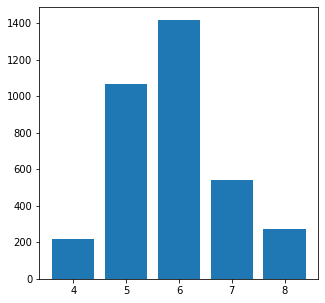

In [238]:
sampling_strategy = {4: 250, 8: 250}

ada = ADASYN(random_state=42, sampling_strategy=sampling_strategy)
X_train_resampled, y_train_resampled = ada.fit_resample(X_train_, y_train_)

# 오버 샘플링 결과
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
var = y_train_resampled.value_counts()
plt.bar(var.index, var)
plt.show()

## PCA 분석 + 2D scatter plot

In [239]:
# y_train에 있는 값의 개수
np.unique(y_train)

array([4, 5, 6, 7, 8])

In [240]:
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

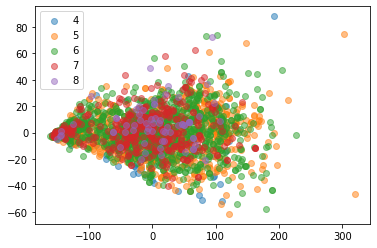

In [241]:
from sklearn.decomposition import PCA
pca= PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_train_pca.shape

# np.unique(y_train) = [4, 5, 6 7, 8]
for l in np.unique(y_train):
    plt.scatter(x=X_train_pca[y_train==l,0],y=X_train_pca[y_train==l,1], alpha=0.5, label=l)

# plt.scatter(x=X_train_pca[y_train==4,0],y=X_train_pca[y_train==4,1], alpha=0.5, label=4)
# plt.scatter(x=X_train_pca[y_train==5,0],y=X_train_pca[y_train==5,1], alpha=0.5, label=5)
# plt.scatter(x=X_train_pca[y_train==6,0],y=X_train_pca[y_train==6,1], alpha=0.5, label=6)
# plt.scatter(x=X_train_pca[y_train==7,0],y=X_train_pca[y_train==7,1], alpha=0.5, label=7)
# plt.scatter(x=X_train_pca[y_train==8,0],y=X_train_pca[y_train==8,1], alpha=0.5, label=8)

plt.legend()


# 하이퍼 파라미터 튜닝

GROUP 1: max_depth , min_child_weight

GROUP 2: subsample, colsample_bytree

GROUP 3: learning_rate, num_boost_round

순차적으로 tuning을 진행한다. 한 그룹의 튜닝을 진행할 때, 다른 모든 그룹은 값을 고정한다. 튜닝을 진행한 값은 고정하여 이후에 다시 변하지 않는다. ```learing_rate, num_boos_round```는 각각 0.1과 1000으로 고정한다

In [242]:
'''
import optuna
from sklearn.metrics import log_loss


# 순차적으로 업데이트를 진행할 것이기 때문에 params dict를 불러온다
def objective(trial, X, y, group, params=dict()):
    ## Initial Learning Parameters
    params['learning_rate'] = 0.1
    params['num_boost_round'] = 1000

    if group == '1':
        params['max_depth'] = trial.suggest_int('max_depth', 2, 5)
        params['min_child_weight'] = trial.suggest_loguniform(
            'min_child_weight', 1e-1, 1e5)

    if group == '2':
        params['subsample'] = trial.suggest_uniform('subsample', 0, 1)
        params['colsample_bytree'] = trial.suggest_uniform(
            'colsample_bytree', 0, 1)

    if group == '3':
        params['learning_rate'] = trial.suggest_uniform(
            'learning_rate', 0, 0.1)
        params['num_boost_round'] = trial.suggest_int('num_boost_round', 100,
                                                      1000)

    model = XGBClassifier(**params)
    loss_list = []
    skf = StratifiedKFold(n_splits=3)
    for train_index, val_index in skf.split(X_train, y_train):
        # print(train_index)
        train_x = X_train.iloc[train_index]
        train_y = y_train.iloc[train_index]
        val_x = X_train.iloc[val_index]
        val_y = y_train.iloc[val_index]
        model.fit(X=X_train,
                  y=y_train,
                  eval_set=[(val_x, val_y)],
                  eval_metric='mlogloss',
                  early_stopping_rounds=30,
                  verbose=False)
        loss = log_loss(y_true=val_y, y_pred=model.predict_proba(val_x))
        loss_list.append(loss)
    # print(f'loss_list = {loss_list}')

    # 평균 loss를 반환한다
    return np.array(loss_list).mean()


# 각 group마다 trials만큼 hyperparameter tuning을 실시한다
study_dict = dict()


def stepwise_optimization(x, y, trials=10):
    final_params = dict()

    for group_num in ['1', '2', '3']:
        print(
            f"=========================== Optimizing Group - {group_num} ============================"
        )

        study = optuna.create_study(direction='minimize')

        study.optimize(lambda trial: objective(
            trial, x, y, group=group_num, params=final_params),
                       n_trials=trials)
        print("BEST CV SCORE", study.best_value)
        print(f"OPTIMAL GROUP - {group_num} PARAMS: ", study.best_params)

        final_params.update(study.best_params)

        study_dict[group_num] = study

    print(f'BEST SCORE : {study.best_value}')
    print(f"PARAMS after optimizing GROUP - {group_num}: ", final_params)
    print()
    print()

    print(
        "=========================== FINAL OPTIMAL PARAMETERS ============================"
    )
    print(final_params)

    return final_params


best_param = stepwise_optimization(x=X_train_resampled,y=y_train_resampled, trials=20)
'''

'\nimport optuna\nfrom sklearn.metrics import log_loss\n\n\n# 순차적으로 업데이트를 진행할 것이기 때문에 params dict를 불러온다\ndef objective(trial, X, y, group, params=dict()):\n    ## Initial Learning Parameters\n    params[\'learning_rate\'] = 0.1\n    params[\'num_boost_round\'] = 1000\n\n    if group == \'1\':\n        params[\'max_depth\'] = trial.suggest_int(\'max_depth\', 2, 5)\n        params[\'min_child_weight\'] = trial.suggest_loguniform(\n            \'min_child_weight\', 1e-1, 1e5)\n\n    if group == \'2\':\n        params[\'subsample\'] = trial.suggest_uniform(\'subsample\', 0, 1)\n        params[\'colsample_bytree\'] = trial.suggest_uniform(\n            \'colsample_bytree\', 0, 1)\n\n    if group == \'3\':\n        params[\'learning_rate\'] = trial.suggest_uniform(\n            \'learning_rate\', 0, 0.1)\n        params[\'num_boost_round\'] = trial.suggest_int(\'num_boost_round\', 100,\n                                                      1000)\n\n    model = XGBClassifier(**params)\n    lo

# 모델 준비

- best_param을 이용하여 모델 정의
- StratifiedKFold를 이용하여 Cross Validation 수행

In [243]:
model = XGBClassifier(objective='multi:softprob')

best_param = {'learning_rate': 0.09986748150113252, 'num_boost_round': 154, 'max_depth': 4, 'min_child_weight': 0.11093080963429129, 'subsample': 0.8359806275799544, 'colsample_bytree': 0.7573975639904268}
model = XGBClassifier(objective='multi:softprob', **best_param)


In [244]:
model.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.7573975639904268,
 'gamma': 0,
 'learning_rate': 0.09986748150113252,
 'max_delta_step': 0,
 'max_depth': 4,
 'min_child_weight': 0.11093080963429129,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'num_boost_round': 154,
 'objective': 'multi:softprob',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 0.8359806275799544,
 'verbosity': 1}

In [245]:
def cv_train(x, y):
    results = []
    skf = StratifiedKFold(n_splits=5)
    for train_index, val_index in skf.split(x, y):
        print(train_index)
        train_x = x.iloc[train_index]
        train_y = y.iloc[train_index]
        val_x = x.iloc[val_index]
        val_y = y.iloc[val_index]
        model.fit(X=x,
                  y=y,
                  eval_set=[(val_x, val_y)],
                  eval_metric=['merror', 'mlogloss'],
                  early_stopping_rounds=10)
        results.append(model.evals_result())

    return results


cv_train(X_train_resampled, y_train_resampled)
# cv_train(X_train, y_train)


[ 615  619  631 ... 3508 3509 3510]
[0]	validation_0-merror:0.467994	validation_0-mlogloss:1.55105
Multiple eval metrics have been passed: 'validation_0-mlogloss' will be used for early stopping.

Will train until validation_0-mlogloss hasn't improved in 10 rounds.
[1]	validation_0-merror:0.459459	validation_0-mlogloss:1.50218
[2]	validation_0-merror:0.455192	validation_0-mlogloss:1.45392
[3]	validation_0-merror:0.438122	validation_0-mlogloss:1.41392
[4]	validation_0-merror:0.433855	validation_0-mlogloss:1.37837
[5]	validation_0-merror:0.423898	validation_0-mlogloss:1.34536
[6]	validation_0-merror:0.43101	validation_0-mlogloss:1.31547
[7]	validation_0-merror:0.426743	validation_0-mlogloss:1.28737
[8]	validation_0-merror:0.42532	validation_0-mlogloss:1.26103
[9]	validation_0-merror:0.416785	validation_0-mlogloss:1.23666
[10]	validation_0-merror:0.41394	validation_0-mlogloss:1.21645
[11]	validation_0-merror:0.421053	validation_0-mlogloss:1.19707
[12]	validation_0-merror:0.41963	validatio

[{'validation_0': {'merror': [0.467994,
    0.459459,
    0.455192,
    0.438122,
    0.433855,
    0.423898,
    0.43101,
    0.426743,
    0.42532,
    0.416785,
    0.41394,
    0.421053,
    0.41963,
    0.418208,
    0.412518,
    0.40825,
    0.40825,
    0.399716,
    0.392603,
    0.384068,
    0.389758,
    0.394026,
    0.389758,
    0.388336,
    0.381223,
    0.372688,
    0.381223,
    0.369844,
    0.372688,
    0.371266,
    0.362731,
    0.361309,
    0.359886,
    0.358464,
    0.354196,
    0.348506,
    0.351351,
    0.351351,
    0.347084,
    0.341394,
    0.339972,
    0.339972,
    0.335704,
    0.334282,
    0.331437,
    0.325747,
    0.322902,
    0.312945,
    0.315789,
    0.311522,
    0.314367,
    0.305832,
    0.307255,
    0.307255,
    0.308677,
    0.30441,
    0.305832,
    0.308677,
    0.30441,
    0.302987,
    0.302987,
    0.302987,
    0.300142,
    0.295875,
    0.294452,
    0.294452,
    0.291607,
    0.290185,
    0.288762,
    0.283073,
  

In [246]:
# validation set accuracy
X_val_pred = model.predict(X_val)
np.mean(X_val_pred == y_val)

0.7863777089783281

In [247]:
# whole set accuracy
X_train_pred = model.predict(X_train_)
np.mean(X_train_pred == y_train_)

0.7798761609907121

# Test set for Submission Predict

In [248]:
pred = model.predict(test)
pred = pd.DataFrame(pred)

## 예측값 분포 분석

In [249]:
pred[0].value_counts()

6    1761
5    1025
7     320
8      71
4      54
Name: 0, dtype: int64

<BarContainer object of 5 artists>

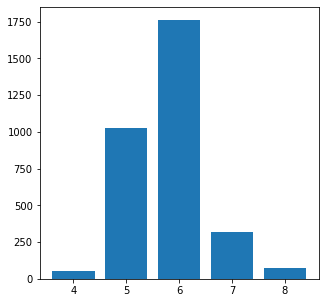

In [250]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
plt.bar(pred[0].value_counts().index, pred[0].value_counts())

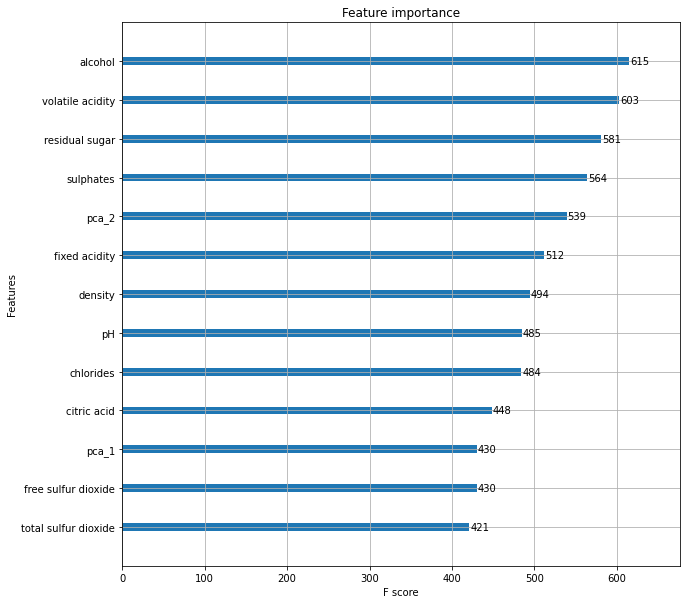

In [251]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
xgboost.plot_importance(model, ax)


In [252]:
test_ = pd.read_csv('./dataset/test.csv')

submission = pd.DataFrame({
    'id': test_.id,
    'quality': pred[0],
})

submission.to_csv('./xgboost_submission.csv', index=False)

In [253]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3230 entries, 0 to 3229
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         3230 non-null   float64
 1   volatile acidity      3230 non-null   float64
 2   citric acid           3230 non-null   float64
 3   residual sugar        3230 non-null   float64
 4   chlorides             3230 non-null   float64
 5   free sulfur dioxide   3230 non-null   float64
 6   total sulfur dioxide  3230 non-null   float64
 7   density               3230 non-null   float64
 8   pH                    3230 non-null   float64
 9   sulphates             3230 non-null   float64
 10  alcohol               3230 non-null   float64
 11  quality               3230 non-null   int64  
 12  pca_1                 3230 non-null   float64
 13  pca_2                 3230 non-null   float64
dtypes: float64(13), int64(1)
memory usage: 353.4 KB


In [254]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3231 entries, 0 to 3230
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         3231 non-null   float64
 1   volatile acidity      3231 non-null   float64
 2   citric acid           3231 non-null   float64
 3   residual sugar        3231 non-null   float64
 4   chlorides             3231 non-null   float64
 5   free sulfur dioxide   3231 non-null   float64
 6   total sulfur dioxide  3231 non-null   float64
 7   density               3231 non-null   float64
 8   pH                    3231 non-null   float64
 9   sulphates             3231 non-null   float64
 10  alcohol               3231 non-null   float64
 11  pca_1                 3231 non-null   float64
 12  pca_2                 3231 non-null   float64
dtypes: float64(13)
memory usage: 328.3 KB
